In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import scipy.stats as stats
import shap

Data importing

In [3]:
file_path = 'glassdoor_jobs.csv'
df = pd.read_csv(file_path)

Dropping irrelevant variables

In [4]:
print(df.shape)
print("Variables in dataset:", "\n", df.columns)

df = df.drop(columns=['Unnamed: 0'])
df = df.drop(columns=['Job Description'])
df = df.drop(columns=['Competitors']) #Companies that compete with the companie listed in the ad


(956, 15)
Variables in dataset: 
 Index(['Unnamed: 0', 'Job Title', 'Salary Estimate', 'Job Description',
       'Rating', 'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors'],
      dtype='object')


In [5]:
print(df.shape)

(956, 12)


In [6]:
def extract_salary_range(salary_str):
    if pd.isna(salary_str) or 'K' not in salary_str or '-' not in salary_str:
        return None

    salary_str = salary_str.split(" ")[0]
    if '-' in salary_str:
        lower, upper = salary_str.split('-')
    else:
        return None

    try:
        #Stripping off dollar sign and 'K' (assuming salaries are in the thousands)
        lower = int(lower.replace('$', '').replace('K', '')) * 1000
        upper = int(upper.replace('$', '').replace('K', '')) * 1000
    except ValueError:
        return None


    return (lower + upper) / 2

df['Salary Estimate'] = df['Salary Estimate'].apply(extract_salary_range)
df['Salary Estimate'] = df['Salary Estimate'].fillna(0).astype(int)


In [7]:
#Numeric variables
numeric = df.select_dtypes(include=['number']).columns
print("Numeric variables: ", numeric)

#Categorical variables
categorical = df.select_dtypes(include=['object']).columns
print("Categorical variables: ", categorical)

#Number of unique values in each categorical variable
print("Number of unique values in each categorical variable", "\n")
for col in categorical:
    print(f"{col}: {df[col].nunique()}")


Numeric variables:  Index(['Salary Estimate', 'Rating', 'Founded'], dtype='object')
Categorical variables:  Index(['Job Title', 'Company Name', 'Location', 'Headquarters', 'Size',
       'Type of ownership', 'Industry', 'Sector', 'Revenue'],
      dtype='object')
Number of unique values in each categorical variable 

Job Title: 328
Company Name: 448
Location: 237
Headquarters: 235
Size: 9
Type of ownership: 13
Industry: 63
Sector: 25
Revenue: 14


Checking for missing and invalid values in dataset

In [8]:
def check_missing_invalid_values(df):
    print("Checking missing values:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])  #only columns with missing values
    print("\n")

    print("Checking invalid values:")
    invalid_values = df.isin(['-1', 'Unknown'])
    invalid_count = invalid_values.sum()

    print(invalid_count[invalid_count > 0])  #only columns with invalid values
    print("\n")


check_missing_invalid_values(df)

Checking missing values:
Series([], dtype: int64)


Checking invalid values:
Headquarters         11
Size                 26
Type of ownership    22
Industry             39
Sector               39
Revenue              11
dtype: int64




In [9]:
def check_variation(df, invalid_categorical):
    for column in invalid_categorical:
        unique_values = df[column].nunique()
        total_values = len(df[column])

        #Percentage of unique values compared to all values
        unique_percentage = (unique_values / total_values) * 100
        print(f"{column} - Unique values: {unique_values} / Total values: {total_values} ({unique_percentage:.2f}% unique values)")

        if unique_percentage < 10:
            print(f" Low variation", "\n")
        else:
            print(f" High variation", "\n")

invalid_categorical = ['Headquarters', 'Size', 'Type of ownership', 'Industry', 'Sector', 'Revenue']
check_variation(df, invalid_categorical)

Headquarters - Unique values: 235 / Total values: 956 (24.58% unique values)
 High variation 

Size - Unique values: 9 / Total values: 956 (0.94% unique values)
 Low variation 

Type of ownership - Unique values: 13 / Total values: 956 (1.36% unique values)
 Low variation 

Industry - Unique values: 63 / Total values: 956 (6.59% unique values)
 Low variation 

Sector - Unique values: 25 / Total values: 956 (2.62% unique values)
 Low variation 

Revenue - Unique values: 14 / Total values: 956 (1.46% unique values)
 Low variation 



Replacing invalid values of categorical variables with LOW VARIATION ​​with the most common value

In [10]:
def replace_invalid_with_mode(df, column):
    mode_value = df[column].mode()[0]
    df[column] = df[column].replace(['-1', 'Unknown'], mode_value)

replace_invalid_with_mode(df, 'Size')
replace_invalid_with_mode(df, 'Type of ownership')
replace_invalid_with_mode(df, 'Industry')
replace_invalid_with_mode(df, 'Sector')
replace_invalid_with_mode(df, 'Revenue')

check_missing_invalid_values(df)

Checking missing values:
Series([], dtype: int64)


Checking invalid values:
Headquarters    11
dtype: int64




Label encoding for Size, Type of ownership, Revenue

In [11]:
def apply_label_encoding(df, columns):
    label_encoders = {}
    for column in columns:
        label_encoder = LabelEncoder()
        df[column + '_encoded'] = label_encoder.fit_transform(df[column])
        label_encoders[column] = label_encoder
    return df, label_encoders

columns_to_encode = ['Size', 'Revenue', 'Type of ownership']

df, label_encoders = apply_label_encoding(df, columns_to_encode)

for column in columns_to_encode:
    print(f"{column} Encoding:")
    print(dict(zip(label_encoders[column].classes_, label_encoders[column].transform(label_encoders[column].classes_))))
    print("\n")

for feature in columns_to_encode:
    print(f"Feature: {feature}")
    print(df[feature].value_counts().sort_index())
    print("-" * 40)

Size Encoding:
{'1 to 50 employees': 0, '10000+ employees': 1, '1001 to 5000 employees': 2, '201 to 500 employees': 3, '5001 to 10000 employees': 4, '501 to 1000 employees': 5, '51 to 200 employees': 6}


Revenue Encoding:
{'$1 to $2 billion (USD)': 0, '$1 to $5 million (USD)': 1, '$10 to $25 million (USD)': 2, '$10+ billion (USD)': 3, '$100 to $500 million (USD)': 4, '$2 to $5 billion (USD)': 5, '$25 to $50 million (USD)': 6, '$5 to $10 billion (USD)': 7, '$5 to $10 million (USD)': 8, '$50 to $100 million (USD)': 9, '$500 million to $1 billion (USD)': 10, 'Less than $1 million (USD)': 11, 'Unknown / Non-Applicable': 12}


Type of ownership Encoding:
{'College / University': 0, 'Company - Private': 1, 'Company - Public': 2, 'Contract': 3, 'Government': 4, 'Hospital': 5, 'Nonprofit Organization': 6, 'Other Organization': 7, 'Private Practice / Firm': 8, 'School / School District': 9, 'Subsidiary or Business Segment': 10}


Feature: Size
Size
1 to 50 employees           61
10000+ employe

Checking the frequency of categorical dummy variables

In [12]:
dummy_cols = columns_to_encode
for col in dummy_cols:
    print(f"\Frequency for {col}:")
    print(df[col].value_counts())

\Frequency for Size:
Size
1001 to 5000 employees     203
201 to 500 employees       160
51 to 200 employees        155
10000+ employees           154
501 to 1000 employees      144
5001 to 10000 employees     79
1 to 50 employees           61
Name: count, dtype: int64
\Frequency for Revenue:
Revenue
Unknown / Non-Applicable            310
$10+ billion (USD)                  140
$100 to $500 million (USD)          107
$1 to $2 billion (USD)               68
$500 million to $1 billion (USD)     62
$25 to $50 million (USD)             59
$50 to $100 million (USD)            52
$2 to $5 billion (USD)               44
$10 to $25 million (USD)             39
$5 to $10 million (USD)              29
$5 to $10 billion (USD)              20
$1 to $5 million (USD)               17
Less than $1 million (USD)            9
Name: count, dtype: int64
\Frequency for Type of ownership:
Type of ownership
Company - Private                 554
Company - Public                  237
Nonprofit Organization   

Correlation matrix with variances at the main diagonal

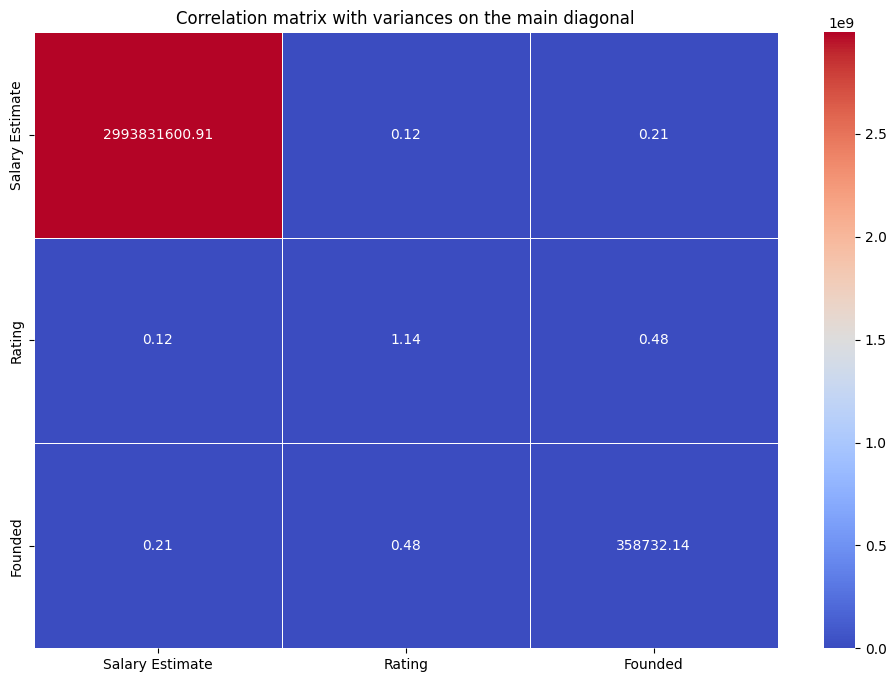

In [13]:
new_numeric = ['Salary Estimate', 'Rating', 'Founded']
corr_matrix = df[new_numeric].corr()
var_matrix = np.diag(df[new_numeric].var())

#Replacing the main diagonal with variances
for i in range(len(new_numeric)):
    corr_matrix.iloc[i, i] = var_matrix[i, i]

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title("Correlation matrix with variances on the main diagonal")
plt.show()

IQR method for allocation of outliers

In [14]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

for col in new_numeric:
    outliers = detect_outliers(df, col)
    print(f"Outliers in {col}: {len(outliers)}")

Outliers in Salary Estimate: 0
Outliers in Rating: 37
Outliers in Founded: 117


Distribution of numerical variables

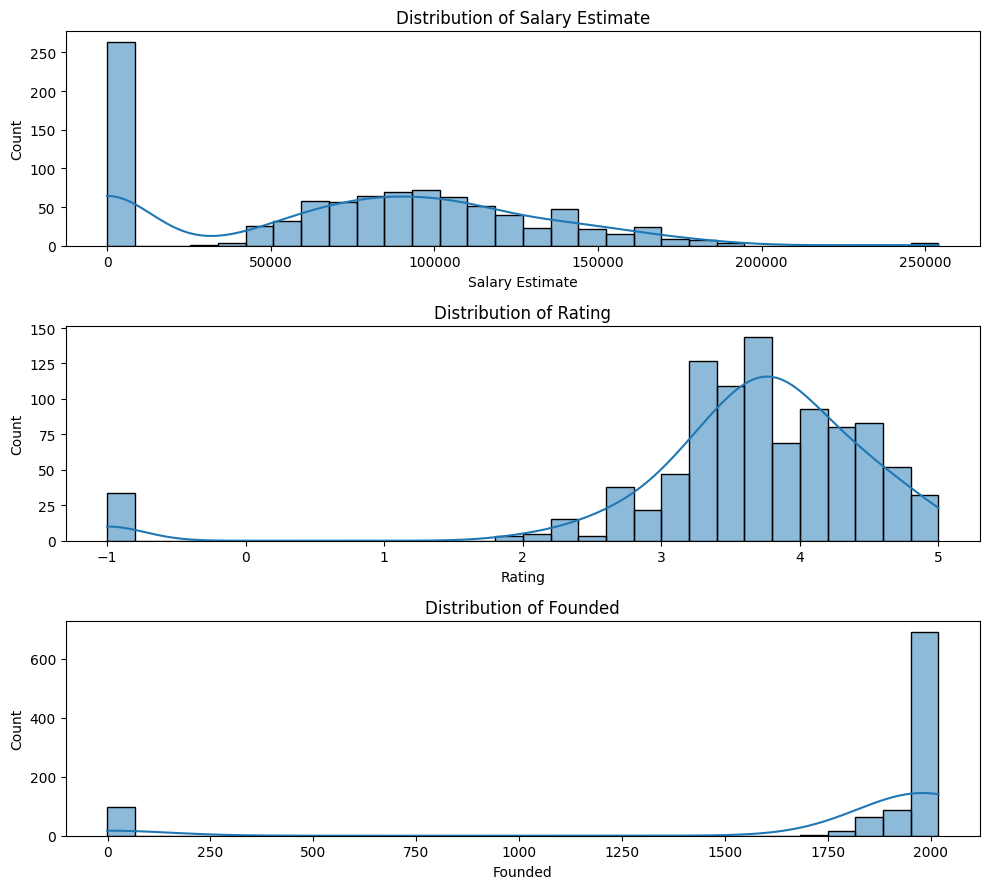

In [15]:
numeric_cols = ['Salary Estimate', 'Rating', 'Founded']
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(10, 3 * len(numeric_cols)))
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

Managing outliers - SALARY ESTIMATE

Salary Estimate
81000     11
87500     11
140000    11
84500     10
85000     10
107500    10
107000    10
87000      9
109000     8
154500     8
Name: count, dtype: int64
Company Name
MassMutual\n3.6                        14
Reynolds American\n3.1                 14
Takeda Pharmaceuticals\n3.7            14
Software Engineering Institute\n2.6    11
PNNL\n3.8                              10
Liberty Mutual Insurance\n3.3          10
AstraZeneca\n3.9                        9
MITRE\n3.2                              8
Fareportal\n3.8                         7
Novartis\n3.8                           7
Name: count, dtype: int64


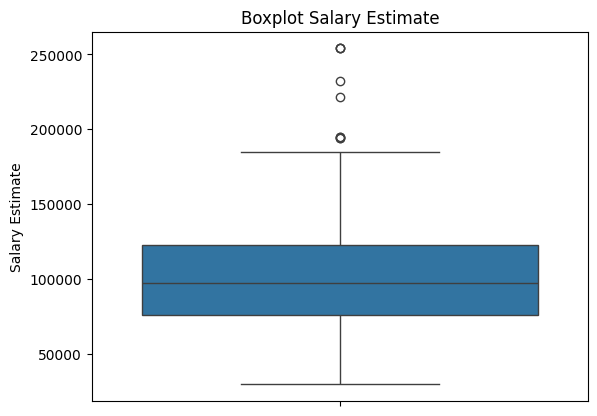

In [16]:
#print(df['Salary Estimate'].value_counts().head(10))
#print(df[df['Salary Estimate'] == 0])  # all rows with Salary Estimate = 0
#print(df[df['Salary Estimate'] == 0].describe(include='all')) #statistics for Salary Estimate = 0
#print(df[df['Salary Estimate'] == 0]['Company Name'].value_counts().head(10)) #companies with Salary Estimate = 0

'''
sns.boxplot(y=df['Salary Estimate'])
plt.title("Boxplot Salary Estimate")
plt.show()

df['Salary Estimate'].hist(bins=20)
plt.title('Distribution of Salary Estimation')
plt.xlabel('Salary Estimation')
plt.ylabel('Frequency')
plt.show()
'''
#Removing rows with Salary Estimate == 0
df = df[df['Salary Estimate'] > 0]

#The most common salary estimate
print(df['Salary Estimate'].value_counts().head(10))

#The most common company
print(df['Company Name'].value_counts().head(10))

sns.boxplot(y=df['Salary Estimate'])
plt.title("Boxplot Salary Estimate")
plt.show()

Managing outliers - RATING

Rating
 3.9    62
 3.8    60
 3.7    56
 3.5    49
 4.0    43
 3.4    41
 3.6    38
 3.3    36
 4.4    33
 3.2    33
 4.7    31
 4.3    29
 4.2    25
 3.1    25
 2.9    18
 3.0    17
 4.1    16
 2.7    12
 2.6    12
 4.6    10
 4.8     9
 2.4     7
 4.5     7
 2.8     7
 2.1     5
 1.9     3
 2.3     2
 2.5     2
 2.2     2
 5.0     1
-1.0     1
Name: count, dtype: int64
Rating
 2.1    5
 1.9    3
 2.2    2
-1.0    1
Name: count, dtype: int64


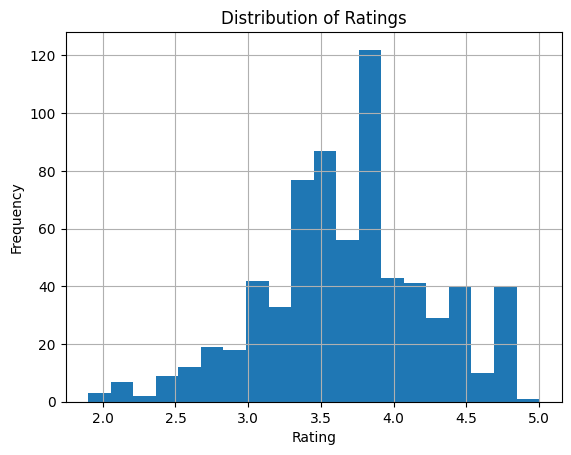

In [17]:
print(df['Rating'].value_counts())

Q1 = df['Rating'].quantile(0.25)
Q3 = df['Rating'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Rating'] < lower_bound) | (df['Rating'] > upper_bound)]
print(outliers['Rating'].value_counts())

#deleted rows with Rating -1
#there are no other outliers, the values ​​are in the range [1, 5]
df = df[df['Rating'] != -1]

df['Rating'].hist(bins=20)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

Managing outliers - FOUNDED

The oldest companies 
      Founded
342     1902
731     1912
637     1912
524     1912
489     1912
913     1912
826     1912
452     1912
785     1912
675     1912
The youngest companies 
      Founded
281     2019
125     2019
705     2017
403     2017
146     2017
949     2017
86      2017
747     2017
576     2017
61      2016
Number of outliers: 26


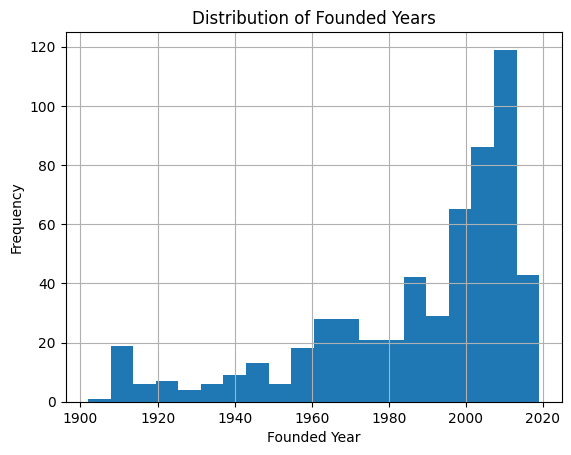

In [18]:
df = df[(df['Founded'] >= 1900) & (df['Founded'] <= 2025)]  #intuitive range for founded year

print("The oldest companies", '\n', df[['Founded']].sort_values(by='Founded').head(10))
print("The youngest companies", '\n', df[['Founded']].sort_values(by='Founded', ascending=False).head(10))

Q1 = df['Founded'].quantile(0.25)
Q3 = df['Founded'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['Founded'] < lower_bound) | (df['Founded'] > upper_bound)]
print(f'Number of outliers: {outliers.shape[0]}')

df['Founded'].hist(bins=20)
plt.title('Distribution of Founded Years')
plt.xlabel('Founded Year')
plt.ylabel('Frequency')
plt.show()

Distribution of numerical variables after managing outliers

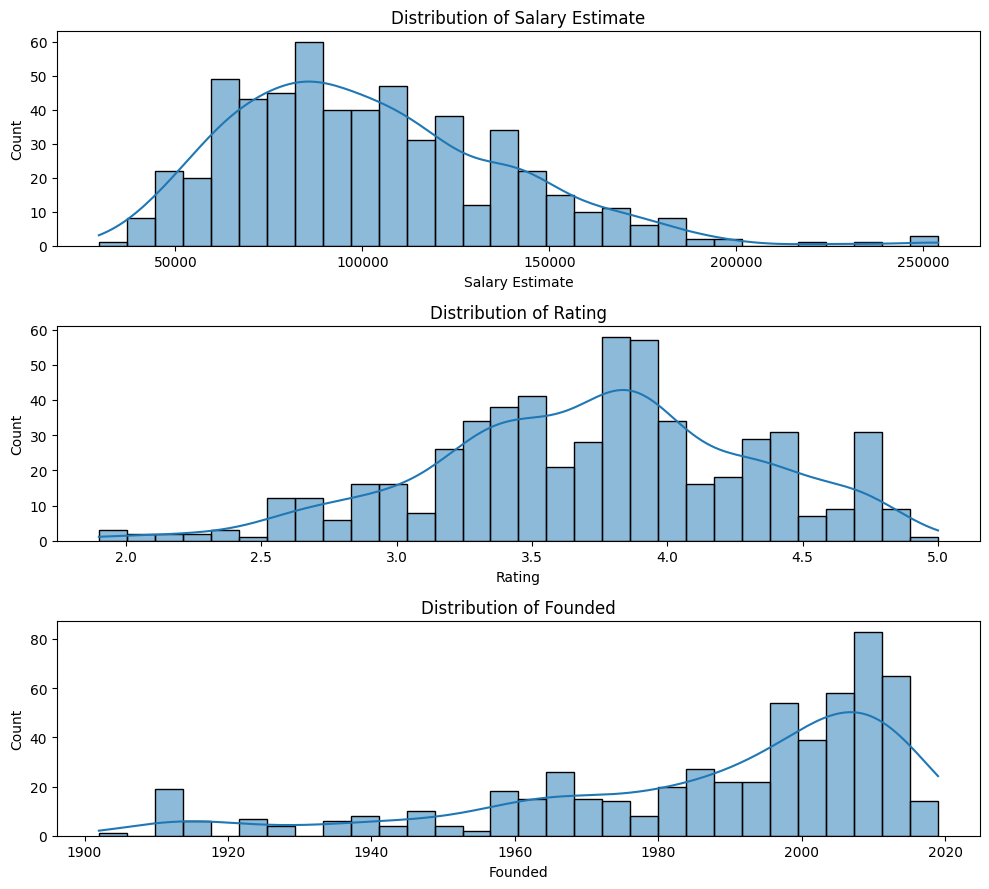

In [19]:
numeric_cols = ['Salary Estimate', 'Rating', 'Founded']
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(10, 3 * len(numeric_cols)))
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

Variance Inflation Factor

In [20]:
X = df[['Rating', 'Founded']]
X = add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

   feature          VIF
0    const  5248.173495
1   Rating     1.011282
2  Founded     1.011282


Linear regression model

In [21]:
def model_evaluation(y_test, y_predicted, N, d):
    mse = np.mean((y_test-y_predicted)**2)
    # mse = mean_squared_error(y_test,y_predicted)
    mae = np.mean(np.abs(y_test-y_predicted))
    # mae = mean_absolute_error(y_test,y_predicted)
    rmse = np.sqrt(mse)
    r2 = 1-np.sum((y_test-y_predicted)**2)/np.sum((y_test-np.mean(y_test))**2)
    # r2 = r2_score(y_test, y_predicted)
    r2_adj = 1-((1-r2)*(N-1))/(N-d-1)

    print('Mean squared error: ', mse)
    print('Mean absolute error: ', mae)
    print('Root mean squared error: ', rmse)
    print('R2 score: ', r2)
    print('R2 adjusted score: ', r2_adj)

    #Comparison of several real and predicted values
    res=pd.concat([pd.DataFrame(y_test.values), pd.DataFrame(y_predicted)], axis=1)
    res.columns = ['y', 'y_pred']
    print(res.head(20))
    return mse,mae,rmse,r2,r2_adj

In [22]:
X = df[['Rating', 'Founded']]  #Input variables
y = df['Salary Estimate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = LinearRegression(fit_intercept=True)

#Model training
model.fit(X_train, y_train)

#Testing the model on the test set (10%)
y_predicted = model.predict(X_test)

In [23]:
model_evaluation(y_test, y_predicted, X_train.shape[0], X_train.shape[1])

Mean squared error:  1173276214.0524397
Mean absolute error:  28798.517399225508
Root mean squared error:  34253.11977108713
R2 score:  -0.03407155474137924
R2 adjusted score:  -0.03812673730899241
         y         y_pred
0    86000  102685.796753
1    77500  106284.305246
2    61000  109288.639171
3    48500  101757.011354
4    99000  102945.841174
5   119000  102594.019117
6    88500  101714.944657
7   121000  103112.665906
8    72500  105355.519846
9    66500   98141.772319
10  139500  103279.971322
11  106500  103112.665906
12  106500   98911.857916
13  114500   98736.427572
14   85500  105690.130678
15   97500   98911.857916
16   37500   98041.389070
17   64000  101330.142201
18  107500   97237.842390
19  139500  106476.946817


(1173276214.0524397,
 28798.517399225508,
 34253.11977108713,
 -0.03407155474137924,
 -0.03812673730899241)

Scatter plot: real VS predicted values

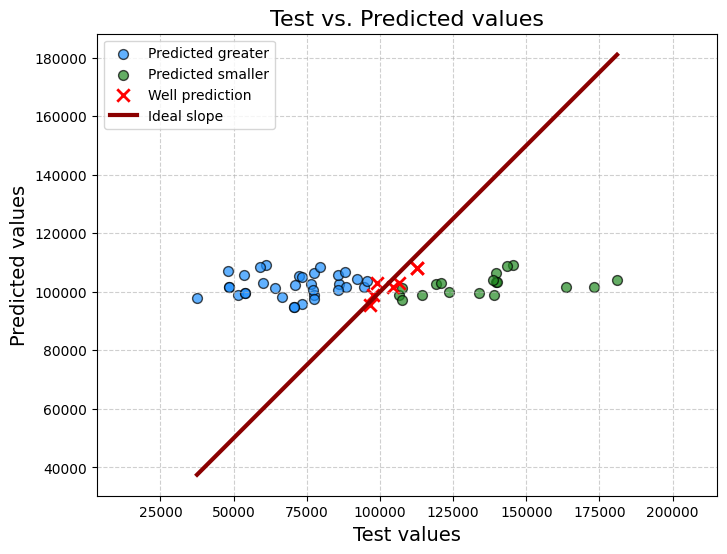

In [36]:
# Defining a threshold for well-predicted values
threshold = 5000
correct_prediction = np.abs(y_predicted - y_test) <= threshold

above_line = y_predicted > y_test # Dots on the plot where is predicted value grater then the real value
below_line = ~above_line  # Dots on the plot where is predicted value smaller (or equal) then the real value

plt.figure(figsize=(8, 6))

# Plotting the dots above the line (blue)
plt.scatter(y_test[above_line & ~correct_prediction], y_predicted[above_line & ~correct_prediction],
            color='dodgerblue', alpha=0.7, edgecolors='black', s=50, label='Predicted greater')

# Plotting the dots under the line (green)
plt.scatter(y_test[below_line & ~correct_prediction], y_predicted[below_line & ~correct_prediction],
            color='forestgreen', alpha=0.7, edgecolors='black', s=50, label='Predicted smaller')

# Well-prediction (red X)
plt.scatter(y_test[correct_prediction], y_predicted[correct_prediction],
            color='red', marker='x', s=80, linewidths=2, label='Well prediction')

# Ideal slope (y = x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='darkred', linestyle='-', linewidth=3, label='Ideal slope')

plt.ylim(50000, 100000)
plt.axis("equal")

plt.title('Test vs. Predicted values', fontsize=16)
plt.xlabel('Test values', fontsize=14)
plt.ylabel('Predicted values', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.show()



Residual histogram

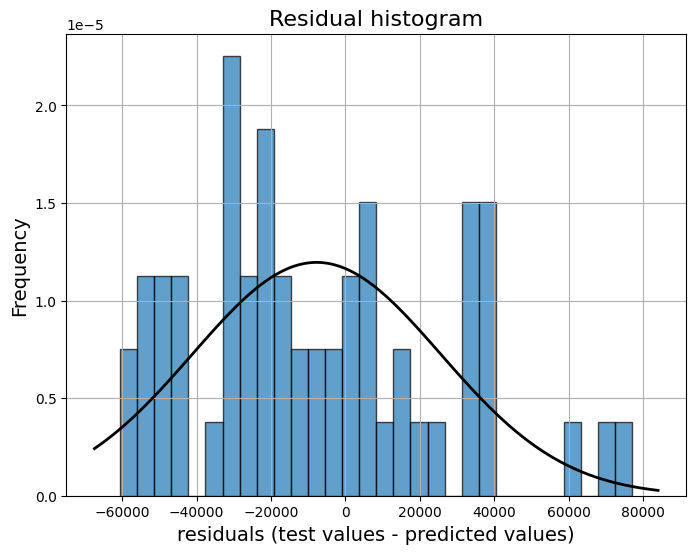

In [25]:
residuals = y_test - y_predicted

mu, std = np.mean(residuals), np.std(residuals)

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7, density=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)


plt.title('Residual histogram', fontsize=16)
plt.xlabel('residuals (test values - predicted values)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()


Ridge - linear regression

In [26]:
model_ridge = Ridge(alpha=5)

model_ridge.fit(X_train, y_train)

y_predicted_ridge = model_ridge.predict(X_test)

model_evaluation(y_test, y_predicted_ridge, X_train.shape[0], X_train.shape[1])

Mean squared error:  1173459405.2391074
Mean absolute error:  28805.01317979907
Root mean squared error:  34255.79374703069
R2 score:  -0.034233011006275404
R2 adjusted score:  -0.03828882673571177
         y         y_pred
0    86000  102696.385534
1    77500  106193.192699
2    61000  109112.902565
3    48500  101777.054542
4    99000  102870.514133
5   119000  102571.903765
6    88500  101764.642835
7   121000  103102.365987
8    72500  105273.861708
9    66500   98263.135692
10  139500  103273.482833
11  106500  103102.365987
12  106500   98989.538176
13  114500   98779.497984
14   85500  105616.095400
15   97500   98989.538176
16   37500   98160.465585
17   64000  101371.074089
18  107500   97399.839732
19  139500  106359.609568


(1173459405.2391074,
 28805.01317979907,
 34255.79374703069,
 -0.034233011006275404,
 -0.03828882673571177)

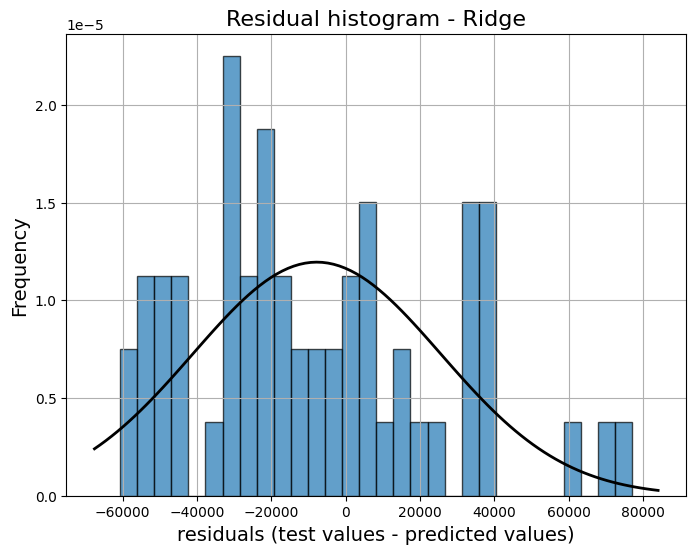

In [27]:
residuals_ridge = y_test - y_predicted_ridge

mu, std = np.mean(residuals_ridge), np.std(residuals_ridge)

plt.figure(figsize=(8, 6))
plt.hist(residuals_ridge, bins=30, edgecolor='black', alpha=0.7, density=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)


plt.title('Residual histogram - Ridge', fontsize=16)
plt.xlabel('residuals (test values - predicted values)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

Lasso - linear regression

In [28]:
model_lasso = Lasso(alpha=0.01)

model_lasso.fit(X_train, y_train)

y_predicted_lasso = model_lasso.predict(X_test)

model_evaluation(y_test, y_predicted_lasso, X_train.shape[0], X_train.shape[1])

Mean squared error:  1173276246.4675508
Mean absolute error:  28798.518551414047
Root mean squared error:  34253.12024425732
R2 score:  -0.03407158331056337
R2 adjusted score:  -0.038126765990212697
         y         y_pred
0    86000  102685.798384
1    77500  106284.288885
2    61000  109288.607834
3    48500  101757.014916
4    99000  102945.828819
5   119000  102594.015507
6    88500  101714.953026
7   121000  103112.663977
8    72500  105355.505417
9    66500   98141.793819
10  139500  103279.969935
11  106500  103112.663977
12  106500   98911.872027
13  114500   98736.436171
14   85500  105690.117333
15   97500   98911.872027
16   37500   98041.410244
17   64000  101330.149322
18  107500   97237.870845
19  139500  106476.926137


(1173276246.4675508,
 28798.518551414047,
 34253.12024425732,
 -0.03407158331056337,
 -0.038126765990212697)

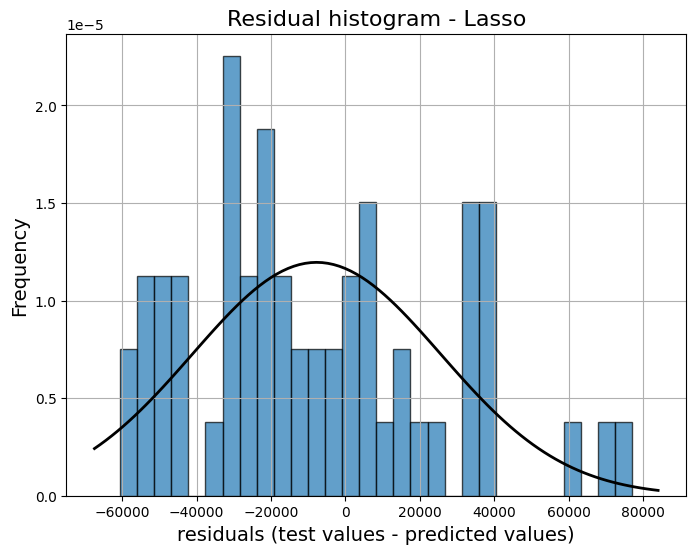

In [29]:
residuals_lasso = y_test - y_predicted_lasso

mu, std = np.mean(residuals_lasso), np.std(residuals_lasso)

plt.figure(figsize=(8, 6))
plt.hist(residuals_lasso, bins=30, edgecolor='black', alpha=0.7, density=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)


plt.title('Residual histogram - Lasso', fontsize=16)
plt.xlabel('residuals (test values - predicted values)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

SHAP analysis

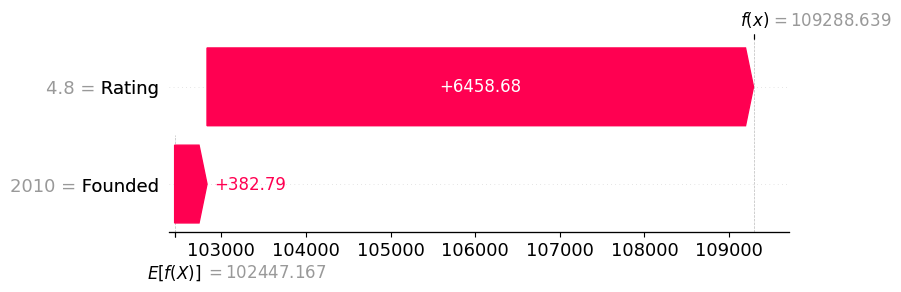

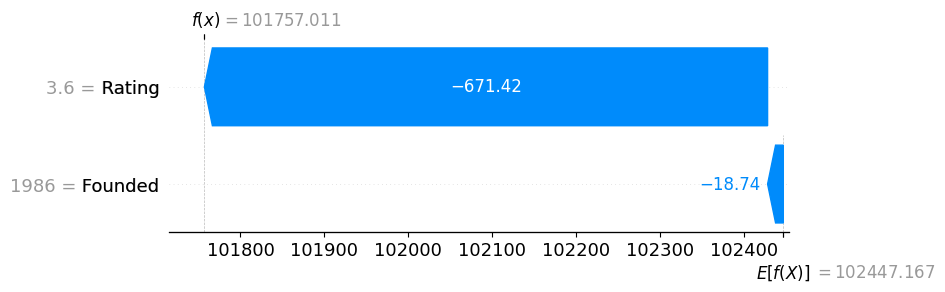

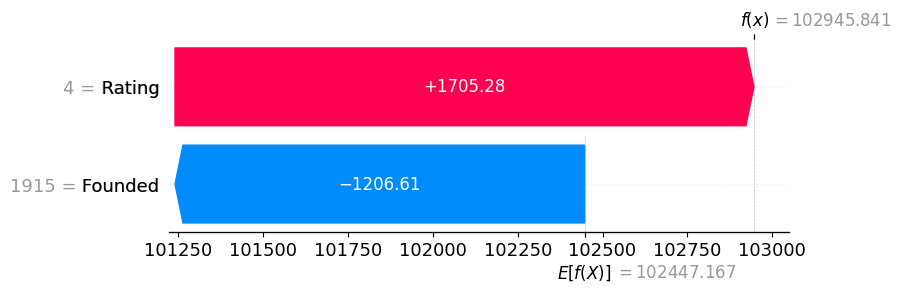

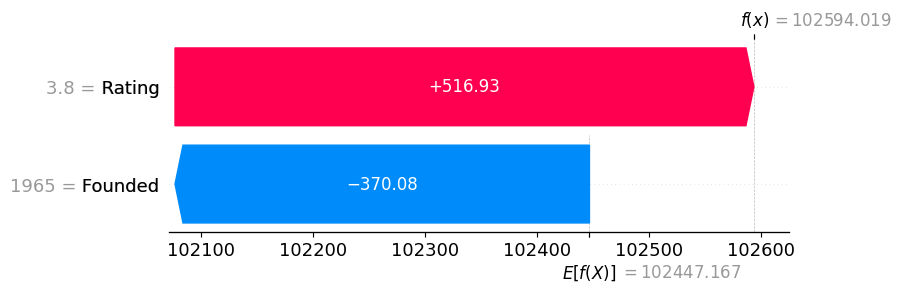

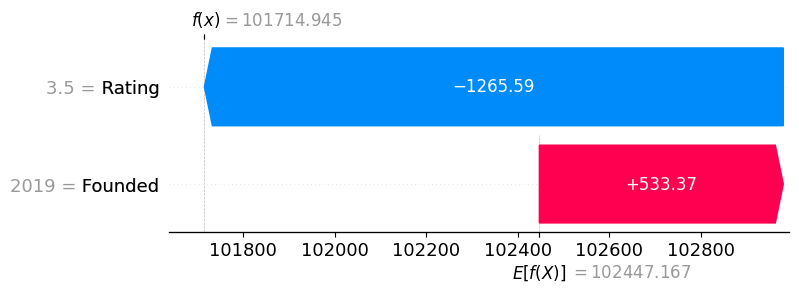

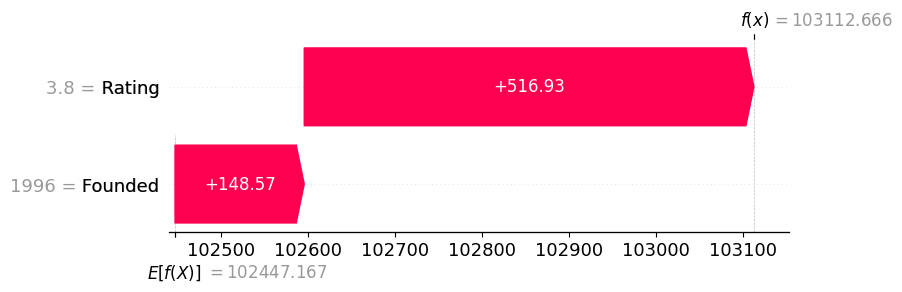

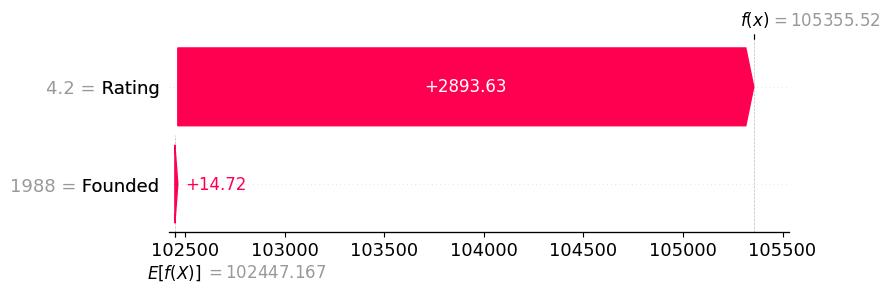

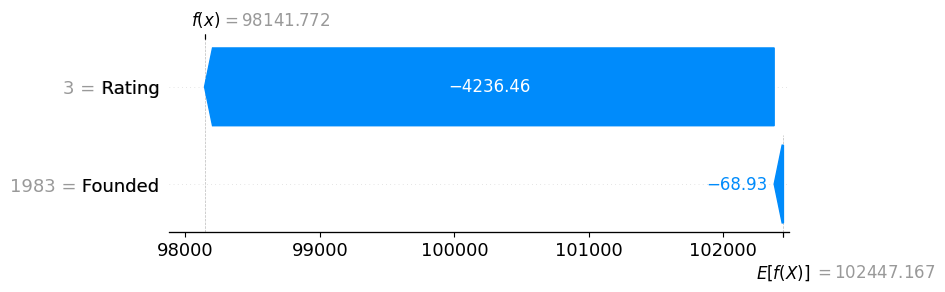

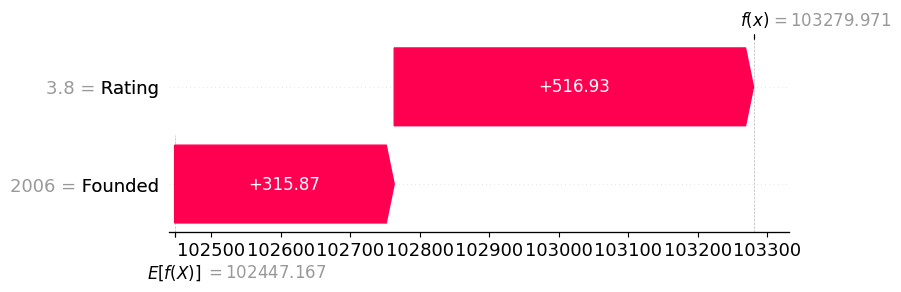

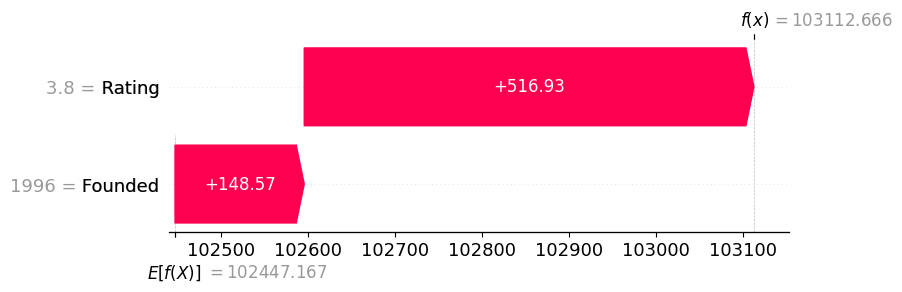

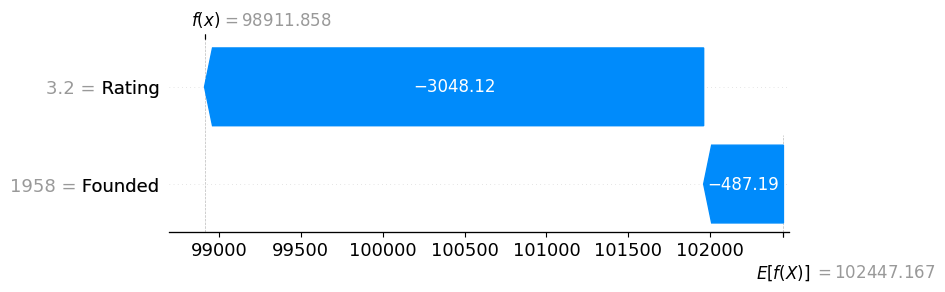

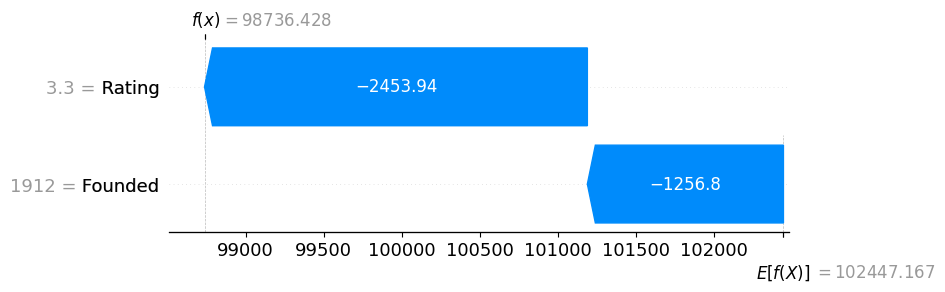

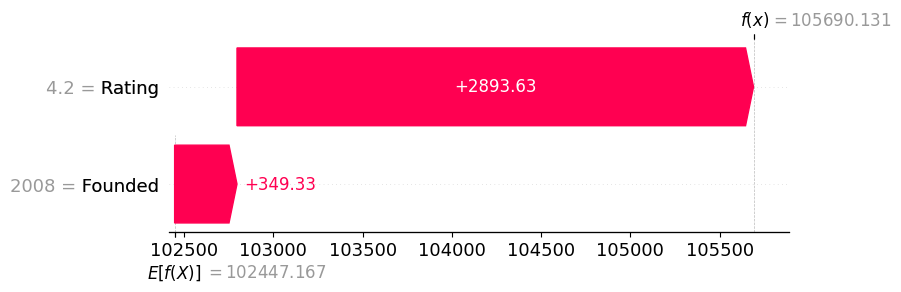

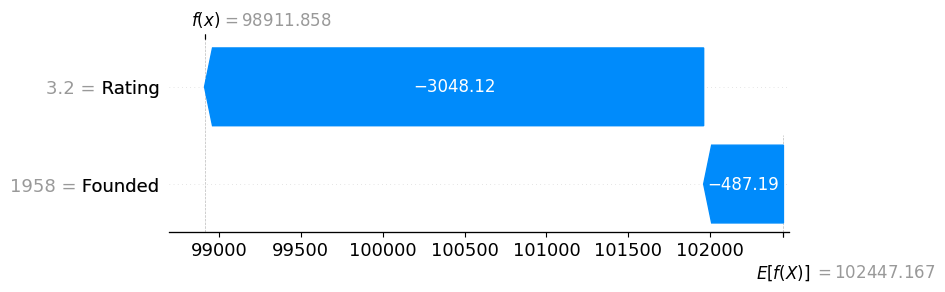

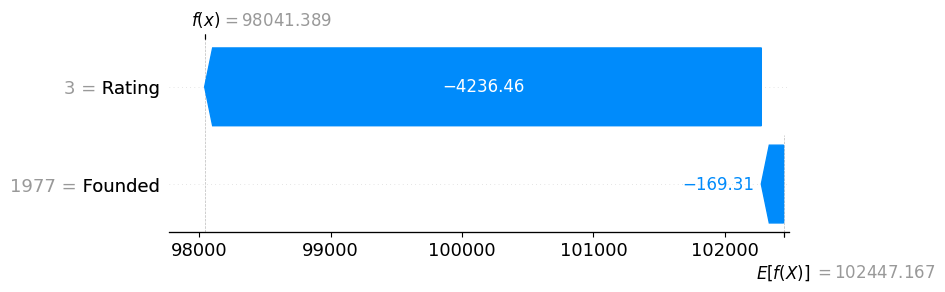

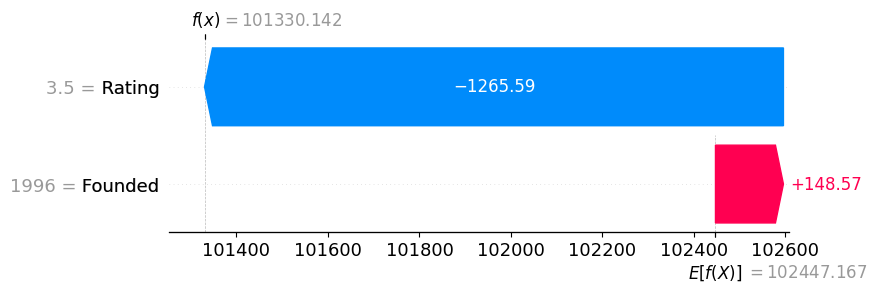

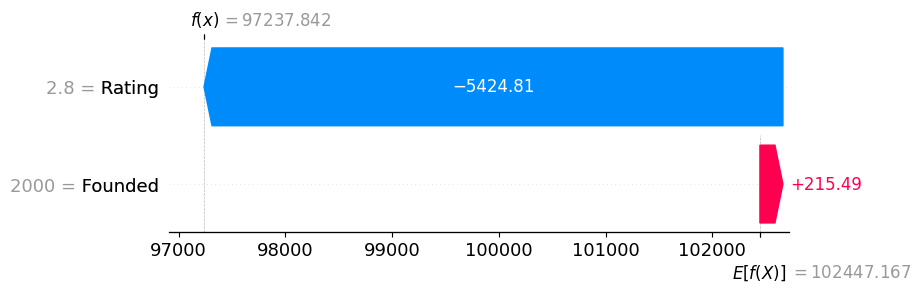

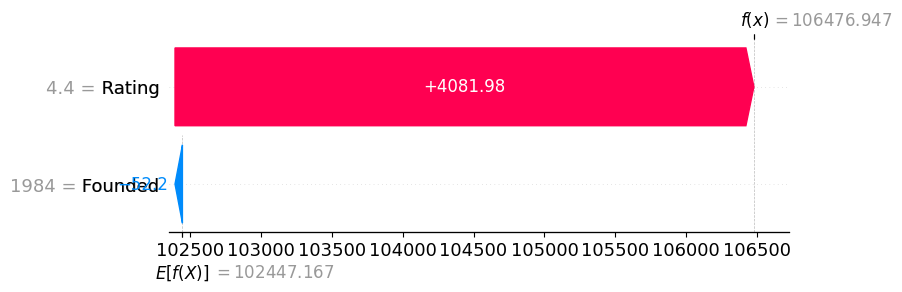

In [30]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
while i < 20:
  shap.waterfall_plot(shap_values[i])
  i = 1 + i

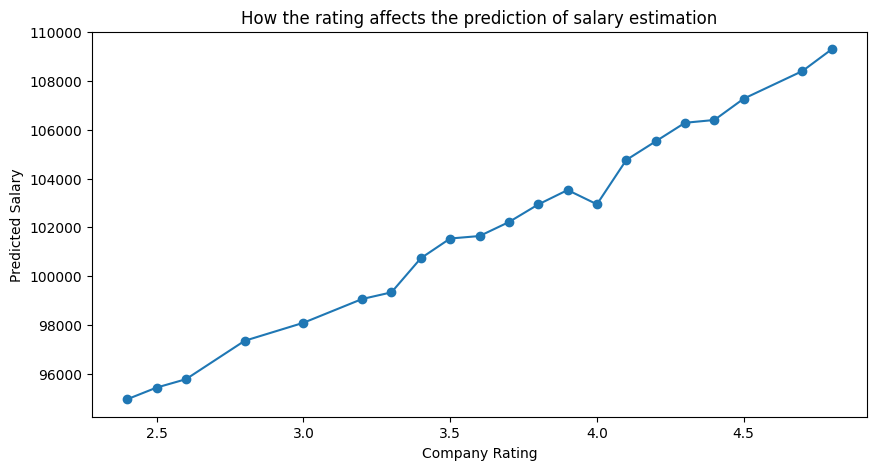

In [31]:
#DataFrame with predictions
df_predicted = pd.DataFrame({"Rating": X_test["Rating"], "Predicted Salary": model.predict(X_test)})

#Group by ratings
df_grouped = df_predicted.groupby("Rating")["Predicted Salary"].mean().reset_index()


plt.figure(figsize=(10, 5))
plt.plot(df_grouped["Rating"], df_grouped["Predicted Salary"], marker='o', linestyle='-')
plt.xlabel("Company Rating")
plt.ylabel("Predicted Salary")
plt.title("How the rating affects the prediction of salary estimation")
plt.show()